In [1]:
import sys
import matplotlib
%matplotlib inline
import argparse
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())
from notebooks.data_loader import load_data
from notebooks.train_val import train
from notebooks.helper_fxns import create_run_dir, dump_hyperparams, get_input_dims
from notebooks.build_network import build_network
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from notebooks/data_loader.ipynb
importing Jupyter notebook from notebooks/train_val.ipynb
importing Jupyter notebook from notebooks/helper_fxns.ipynb
importing Jupyter notebook from notebooks/print_n_plot.ipynb
importing Jupyter notebook from notebooks/build_network.ipynb


In [2]:
num_epochs = 100
learning_rate = 0.1
num_events = 40
weight_decay = 0
num_filters = 100
num_fc_units = 50
dropout_p = 0
# parser = argparse.ArgumentParser()
# parser.add_argument('-e', '--epochs', type=int, default=10,
#     help='number of epochs for training')

# parser.add_argument('-l', '--learn_rate', default=0.0001, type=float,
#     help='the learning rate for the network')

# parser.add_argument('-n', '--num_events', default=40, type=int,
#     help='number of total images')

# args = parser.parse_args()
# num_epochs = args.epochs
# learning_rate = args.learn_rate
# num_events = args.num_events

In [3]:
run_dir = create_run_dir()

In [4]:
dataset = load_data(num_events=1000, num_files=4, bin_size=0.1)

Welcome to ROOTaaS 6.06/06


Starting training...
Epoch 1 of 100 took 26.501s
	training los:		0.6933
	training acc:		50.1953 %
  validation loss:		1.024336
  validation accuracy:		46.50 %
Epoch 2 of 100 took 26.020s
	training los:		6.4599
	training acc:		55.8594 %
  validation loss:		0.703762
  validation accuracy:		53.50 %
Epoch 3 of 100 took 25.563s
	training los:		0.7183
	training acc:		49.0234 %
  validation loss:		0.689203
  validation accuracy:		53.50 %
Epoch 4 of 100 took 25.822s
	training los:		0.6946
	training acc:		48.8281 %
  validation loss:		0.659442
  validation accuracy:		53.50 %
Epoch 5 of 100 took 25.406s
	training los:		0.6795
	training acc:		62.3047 %
  validation loss:		0.648409
  validation accuracy:		46.50 %
Epoch 6 of 100 took 25.242s
	training los:		0.5994
	training acc:		87.3047 %
  validation loss:		0.449606
  validation accuracy:		99.00 %
Epoch 7 of 100 took 25.806s
	training los:		0.2812
	training acc:		96.2891 %
  validation loss:		0.115414
  validation accuracy:		96.00 %
Epoch 8 of 10

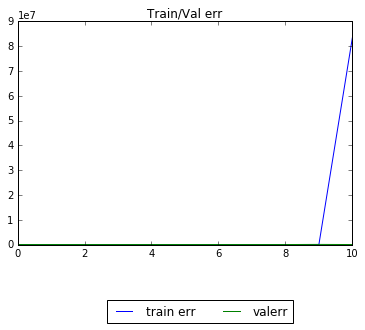

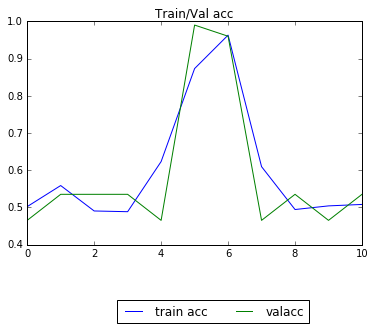

Epoch 12 of 100 took 25.634s
	training los:		43.8086
	training acc:		50.5859 %
  validation loss:		1.166007
  validation accuracy:		46.50 %
Epoch 13 of 100 took 25.832s
	training los:		0.9787
	training acc:		49.8047 %
  validation loss:		0.812379
  validation accuracy:		46.50 %
Epoch 14 of 100 took 25.640s
	training los:		0.7219
	training acc:		51.9531 %
  validation loss:		0.692257
  validation accuracy:		53.50 %
Epoch 15 of 100 took 25.619s
	training los:		0.7074
	training acc:		48.8281 %
  validation loss:		0.702977
  validation accuracy:		53.50 %
Epoch 16 of 100 took 25.332s
	training los:		0.7267
	training acc:		48.8281 %
  validation loss:		0.697892
  validation accuracy:		53.50 %
Epoch 17 of 100 took 24.728s
	training los:		0.7084
	training acc:		49.0234 %
  validation loss:		0.691260
  validation accuracy:		53.50 %
Epoch 18 of 100 took 27.503s
	training los:		0.6934
	training acc:		51.7578 %
  validation loss:		0.701990
  validation accuracy:		46.50 %
Epoch 19 of 100 took 25.30

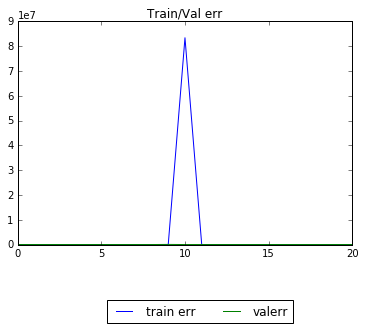

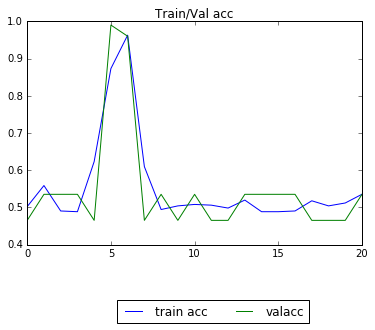

Epoch 22 of 100 took 25.314s
	training los:		0.6942
	training acc:		48.2422 %
  validation loss:		0.691303
  validation accuracy:		53.50 %
Epoch 23 of 100 took 25.617s
	training los:		0.6940
	training acc:		49.6094 %
  validation loss:		0.691952
  validation accuracy:		53.50 %
Epoch 24 of 100 took 24.214s
	training los:		0.6942
	training acc:		49.8047 %
  validation loss:		0.693963
  validation accuracy:		46.50 %
Epoch 25 of 100 took 25.460s
	training los:		0.6931
	training acc:		50.3906 %
  validation loss:		0.694285
  validation accuracy:		46.50 %
Epoch 26 of 100 took 25.731s
	training los:		0.6931
	training acc:		50.9766 %
  validation loss:		0.694631
  validation accuracy:		46.50 %
Epoch 27 of 100 took 25.370s
	training los:		0.6932
	training acc:		51.3672 %
  validation loss:		0.696253
  validation accuracy:		46.50 %
Epoch 28 of 100 took 25.487s
	training los:		0.6943
	training acc:		49.4141 %
  validation loss:		0.693832
  validation accuracy:		46.50 %
Epoch 29 of 100 took 26.904

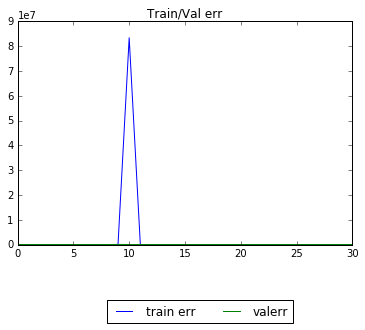

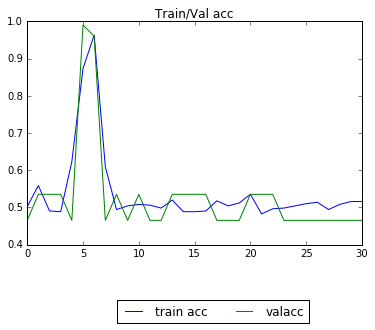

Epoch 32 of 100 took 26.277s
	training los:		0.6940
	training acc:		49.6094 %
  validation loss:		0.693973
  validation accuracy:		46.50 %
Epoch 33 of 100 took 27.492s
	training los:		0.6933
	training acc:		50.3906 %
  validation loss:		0.693628
  validation accuracy:		46.50 %
Epoch 34 of 100 took 26.186s
	training los:		0.6941
	training acc:		51.7578 %
  validation loss:		0.691699
  validation accuracy:		53.50 %
Epoch 35 of 100 took 27.097s
	training los:		0.6949
	training acc:		48.2422 %
  validation loss:		0.694093
  validation accuracy:		46.50 %
Epoch 36 of 100 took 27.934s
	training los:		0.6935
	training acc:		49.2188 %
  validation loss:		0.693897
  validation accuracy:		46.50 %
Epoch 37 of 100 took 28.009s
	training los:		0.6934
	training acc:		49.8047 %
  validation loss:		0.692814
  validation accuracy:		53.50 %
Epoch 38 of 100 took 27.821s
	training los:		0.6934
	training acc:		51.1719 %
  validation loss:		0.692833
  validation accuracy:		53.50 %
Epoch 39 of 100 took 27.917

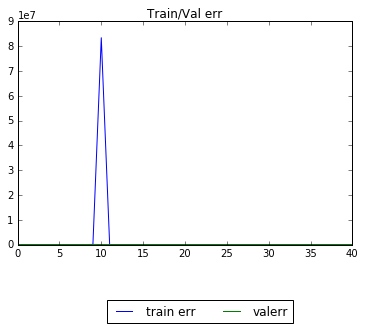

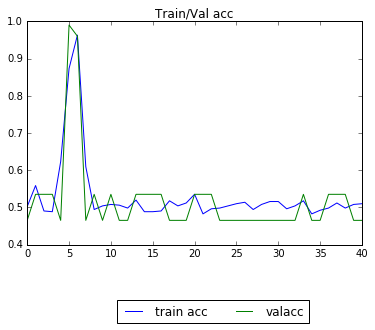

Epoch 42 of 100 took 27.777s
	training los:		0.6929
	training acc:		51.7578 %
  validation loss:		0.695637
  validation accuracy:		46.50 %
Epoch 43 of 100 took 28.430s
	training los:		0.6939
	training acc:		50.0000 %
  validation loss:		0.695182
  validation accuracy:		46.50 %
Epoch 44 of 100 took 27.992s
	training los:		0.6933
	training acc:		51.3672 %
  validation loss:		0.694254
  validation accuracy:		46.50 %
Epoch 45 of 100 took 27.206s
	training los:		0.6934
	training acc:		51.5625 %
  validation loss:		0.696108
  validation accuracy:		46.50 %
Epoch 46 of 100 took 25.518s
	training los:		0.6929
	training acc:		51.1719 %
  validation loss:		0.695727
  validation accuracy:		46.50 %
Epoch 47 of 100 took 25.835s
	training los:		0.6919
	training acc:		52.7344 %
  validation loss:		0.696720
  validation accuracy:		46.50 %
Epoch 48 of 100 took 24.481s
	training los:		0.6940
	training acc:		49.8047 %
  validation loss:		0.695475
  validation accuracy:		46.50 %
Epoch 49 of 100 took 27.630

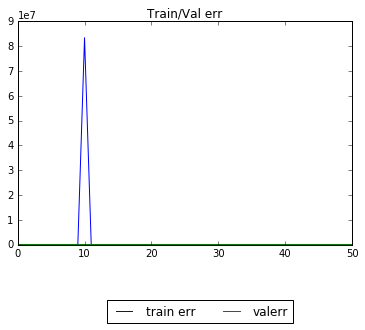

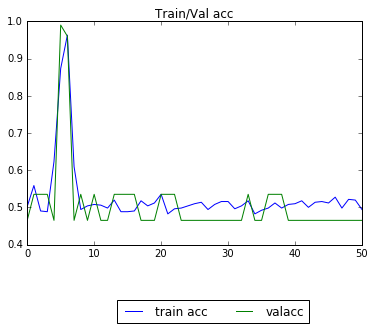

Epoch 52 of 100 took 25.725s
	training los:		0.6938
	training acc:		48.2422 %
  validation loss:		0.692171
  validation accuracy:		53.50 %
Epoch 53 of 100 took 26.136s
	training los:		0.6938
	training acc:		49.6094 %
  validation loss:		0.693251
  validation accuracy:		46.50 %
Epoch 54 of 100 took 25.838s
	training los:		0.6932
	training acc:		50.5859 %
  validation loss:		0.693987
  validation accuracy:		46.50 %
Epoch 55 of 100 took 26.187s
	training los:		0.6932
	training acc:		50.3906 %
  validation loss:		0.694330
  validation accuracy:		46.50 %
Epoch 56 of 100 took 26.865s
	training los:		0.6938
	training acc:		50.1953 %
  validation loss:		0.694311
  validation accuracy:		46.50 %
Epoch 57 of 100 took 26.555s
	training los:		0.6930
	training acc:		51.3672 %
  validation loss:		0.693748
  validation accuracy:		46.50 %
Epoch 58 of 100 took 26.070s
	training los:		0.6933
	training acc:		49.8047 %
  validation loss:		0.692472
  validation accuracy:		53.50 %
Epoch 59 of 100 took 26.623

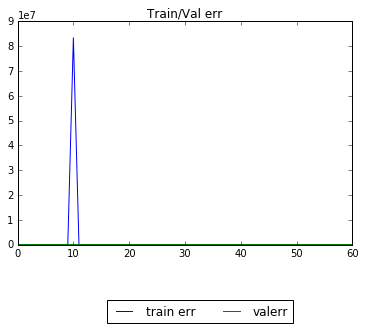

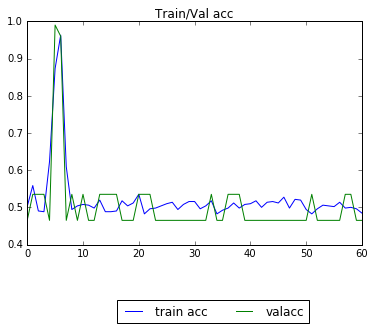

Epoch 62 of 100 took 25.812s
	training los:		0.6932
	training acc:		50.7812 %
  validation loss:		0.693248
  validation accuracy:		46.50 %
Epoch 63 of 100 took 30.416s
	training los:		0.6929
	training acc:		52.5391 %
  validation loss:		0.695267
  validation accuracy:		46.50 %
Epoch 64 of 100 took 26.303s
	training los:		0.6940
	training acc:		50.7812 %
  validation loss:		0.697147
  validation accuracy:		46.50 %
Epoch 65 of 100 took 24.522s
	training los:		0.6931
	training acc:		51.7578 %
  validation loss:		0.696927
  validation accuracy:		46.50 %
Epoch 66 of 100 took 25.843s
	training los:		0.6934
	training acc:		50.7812 %
  validation loss:		0.695606
  validation accuracy:		46.50 %
Epoch 67 of 100 took 27.247s
	training los:		0.6931
	training acc:		51.1719 %
  validation loss:		0.693810
  validation accuracy:		46.50 %
Epoch 68 of 100 took 25.767s
	training los:		0.6939
	training acc:		51.3672 %
  validation loss:		0.693361
  validation accuracy:		46.50 %
Epoch 69 of 100 took 26.132

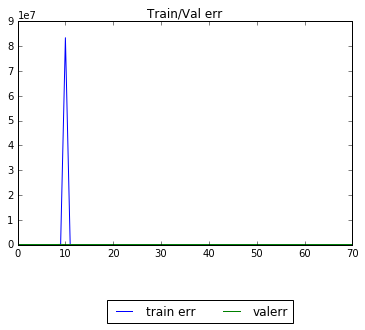

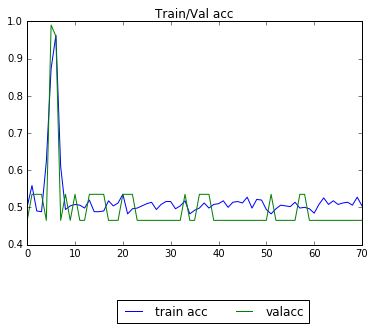

Epoch 72 of 100 took 26.843s
	training los:		0.6931
	training acc:		50.5859 %
  validation loss:		0.693998
  validation accuracy:		46.50 %
Epoch 73 of 100 took 26.539s
	training los:		0.6934
	training acc:		51.3672 %
  validation loss:		0.695899
  validation accuracy:		46.50 %
Epoch 74 of 100 took 28.093s
	training los:		0.6932
	training acc:		51.7578 %
  validation loss:		0.696823
  validation accuracy:		46.50 %
Epoch 75 of 100 took 25.536s
	training los:		0.6943
	training acc:		51.5625 %
  validation loss:		0.697547
  validation accuracy:		46.50 %
Epoch 76 of 100 took 25.387s
	training los:		0.6941
	training acc:		50.7812 %
  validation loss:		0.693715
  validation accuracy:		46.50 %
Epoch 77 of 100 took 25.923s
	training los:		0.6931
	training acc:		51.5625 %
  validation loss:		0.692270
  validation accuracy:		53.50 %
Epoch 78 of 100 took 25.539s
	training los:		0.6939
	training acc:		48.6328 %
  validation loss:		0.692543
  validation accuracy:		53.50 %
Epoch 79 of 100 took 25.896

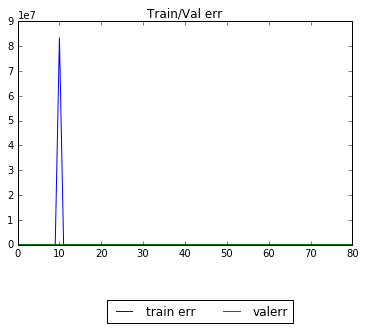

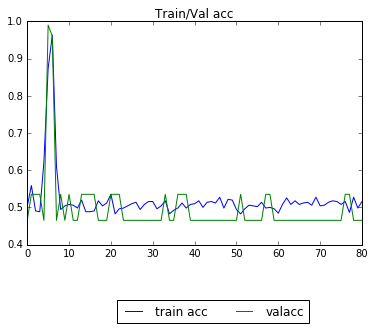

Epoch 82 of 100 took 28.523s
	training los:		0.6939
	training acc:		50.7812 %
  validation loss:		0.696511
  validation accuracy:		46.50 %
Epoch 83 of 100 took 27.164s
	training los:		0.6940
	training acc:		49.6094 %
  validation loss:		0.693196
  validation accuracy:		46.50 %
Epoch 84 of 100 took 28.842s
	training los:		0.6935
	training acc:		52.3438 %
  validation loss:		0.692035
  validation accuracy:		53.50 %
Epoch 85 of 100 took 28.819s
	training los:		0.6936
	training acc:		48.8281 %
  validation loss:		0.692630
  validation accuracy:		53.50 %
Epoch 86 of 100 took 28.683s
	training los:		0.6934
	training acc:		51.5625 %
  validation loss:		0.694664
  validation accuracy:		46.50 %
Epoch 87 of 100 took 27.209s
	training los:		0.6937
	training acc:		49.6094 %
  validation loss:		0.694803
  validation accuracy:		46.50 %


In [ ]:
'''set params'''
network_kwargs = {'input_shape':(None, dataset[0].shape[1], dataset[0].shape[2], dataset[0].shape[3]), 'learning_rate': learning_rate, 'dropout_p': dropout_p, 
                  'weight_decay': weight_decay, 'num_filters': num_filters, 'num_fc_units': num_fc_units}

'''get network and train_fns'''
train_fn, val_fn, network, hyperparams = build_network(**network_kwargs)

'''save hyperparams'''
dump_hyperparams(hyperparams, path=run_dir)

'''train'''
train(dataset, network=network,train_fn=train_fn, val_fn=val_fn, num_epochs=num_epochs, save_path=run_dir)